In [1]:
from IPython.display import display, HTML, IFrame, Image

#### PyCon UK 2015 - Science track

<br/>

##Getting meaning from scientific articles



<br/><br/>
<span><h3> Eleonore Mayola, PhD</h3>
<h4>Data wrangler at Mastodonc</h4>
<h4>Organiser at PyLadies London</h4></span>

####Getting meaning from scientific articles

1- Who I am

2- Goal of this project

3- My plan

4- First iteration

5- Improvements

6- Second iteration

7- Discussion


####Getting meaning from scientific articles

__1- Who I am__

2- Goal of this project

3- My plan

4- First iteration

5- Improvements

6- Second iteration

7- Discussion


####Who I am

* Background in biomedical research 


* Learned Python at an intensive course 


* Now developer, data wrangler, hardware tinkerer




=> What would I have done had I known how to code back in my lab days?

####Getting meaning from scientific articles

1- Who I am

__2- Goal of this project__

3- My plan

4- First iteration

5- Improvements

6- Second iteration

7- Discussion


####Goal of the project

*Problem*: Bibliography is an important activity that takes time off research work.
![Plan chart](img/phdComics1_.png)
   
 -> Could the bibliography process be less time-consuming?



*Idea*: What if it was possible to classify a new article in one of those sub-categories

####Getting meaning from scientific articles

1- Who I am

2- Goal of this project

__3- My plan__

4- First iteration

5- Improvements

6- Second iteration

7- Discussion

####My plan


![Plan chart](img/precursor-doc-0.png)                                         
                                                           

####Getting meaning from scientific articles

1- Who I am

2- Goal of this project

3- My plan

__4- First iteration__

5- Improvements

6- Second iteration

7- Discussion

####First iteration


STEP 1: Gathering scientific articles


![Plan chart](img/precursor-doc-1.png)


####First iteration


STEP 1: Gathering scientific articles

1 - Yay for Open Access research articles!

2 - Hmmm, where's the API so I can upload hundreds of them?

3 - My solution: eLifeScience articles on Github (http://github.com/elifesciences/elife-articles)

4 - Parsing XML files using Beautiful Soup -> Group A: "Neuroscience" - Group B: "Cell biology"


####First iteration



STEP 2: Retrieve the most frequent terms

![Plan chart](img/precursor-doc-2.png)

####First iteration


STEP 2: Retrieve the most frequent terms
 
-> Use Nltk and Gensim libraries to implement the TF-IDF (Term frequency–inverse document frequency) model

->Write functions to be executed on a collection of text files (converted from XML)

In [5]:
# %load get_topics.py

#!/home/eleonore/virtenvs/nltk-gensim-skl/bin/python2.7
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import models
from gensim.corpora import Dictionary
from os import listdir
from os.path import isfile, join
import string, re, codecs, time, json


## Global variables
stop_words = ['a', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'but', 'for',
              'from', 'has', 'he', 'if', 'in', 'is', 'it', 'its', 'it\'s', 'not',
              'of', 'on', 'our', 'than', 'that', 'the', 'therefore', 'to', 'was',
              'were', 'will', 'with', 'may', 'need', 'have', 'been', 'their', 'this',
              'these', 'which', 'do', 'did', 'red', 'blue', 'green', 'bar', 'chart',
              'arrowhead', 'arrow', 'vice', 'versa']

spe_char = {u'β': 'beta', u'α': 'alpha', u'µm': 'micron'}

## Functions to break up the process:
def parse_text(text_file):
    "Gets a text file outputs a list of strings."
    with codecs.open(text_file, mode='r', encoding='utf-8') as f:
        read = f.read()
        r = [read.replace(unicode(i), spe_char.get(i)) for i in read if i in spe_char.keys()] or [read]
        text = [line for line in r[0].strip().split('. ') if line != '']
        return text
    
def get_tokens(text_parsed):
    "Gets a text and retrieves tokens."
    # Tokenisation
    texts = [t.lower().replace('\n', ' ').split(' ') for t in text_parsed]
    # Remove punctuation and stop words
    tokens = [[filter(lambda x:x not in string.punctuation, i)
               for i in txt if i != '' and i not in stop_words] for txt in texts]
    
    tokens_cleaned = [[i for i in txt if len(i) > 2 and not i.isdigit()] for txt in tokens]
    
    return tokens_cleaned

def lemmatize_tokens(tokens):
    "Gets tokens and retrieves lemmatised tokens."
    # Lemmatisation using nltk lemmatiser
    lmtzr = WordNetLemmatizer()
    lemma = [[lmtzr.lemmatize(word) for word in data] for data in tokens]
    return lemma

def bag_of_words(lemma):
    "Takes in lemmatised words and returns a bow."
    ## Create bag of words from dictionnary
    dictionary = Dictionary(lemma)
    dictionary.save('text.dict')
    ## Term frequency–inverse document frequency (TF-IDF)
    bow = [dictionary.doc2bow(l) for l in lemma]
    return bow

def tfidf_and_lsi(lemma, bow):
    "Gets a bow and returns topics."
    dictionary = Dictionary(lemma)
    # Transform the count representation into the Tfidf space
    tfidf = models.TfidfModel(bow) 
    corpus_tfidf = tfidf[bow]
    ## Build the LSI model
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=6)
    corpus_lsi = lsi[corpus_tfidf]
    list_topics = []
    for i in range(lsi.num_topics):
        list_topics.extend(lsi.show_topic(i))
    list_topics.sort(key=lambda tup: tup[0], reverse=True)
    topics = [i[1] for i in list_topics[:10]]
    return topics

## Function to retrieve topics using nltk
def get_topics(text_file):
    txt = parse_text(text_file)
    tokens = get_tokens(txt)
    lemma = lemmatize_tokens(tokens)
    bow = bag_of_words(lemma)
    return tfidf_and_lsi(lemma, bow)

## Get all text articles from a path and retrieve topics:
def list_all_articles(path):
    articles = [f for f in listdir(path) if isfile(join(path, f))] or []
    print "There are %d articles in %s" % (len(articles), path)
    return {"path": path, "articles": articles}

# Write the topics to a json file:
#{"Neuroscience": {"pub_id1":[topics_file1], "pub_id2":[topics_file2]...},
# "Cell biology": {[], []...}}
def get_articles_topics(path, filename):
    "Store the topics in a json object and dump to a file."
    all_topics = {}
    #Get the directories in a path
    dirs = [d for d in listdir(path) if not isfile(join(path, d))]
    #For each dir and for each file in a dir
    for d in dirs:
        all_topics[d] = {}
        txt_files = [f for f in listdir(path+d) if isfile(join(path+d, f))]
        print txt_files
        for f in txt_files:
            all_topics[d][f[:-4]] = get_topics(path+d+'/'+f)
    with open(filename, 'w') as f:
        json.dump(all_topics, f)
    return all_topics
    

if __name__ == "__main__":

    neuro_articles = list_all_articles("articles/Neuroscience/")
    
    cellbiol_articles = list_all_articles("articles/Cell biology/")
    
    print get_topics(neuro_articles.get("path") + neuro_articles.get("articles")[0])

    #print get_articles_topics("articles/", "json/filenames_topics.json")   


There are 172 articles in articles/Neuroscience/
There are 67 articles in articles/Cell biology/
[u'scale', u'colocalization', u'vglut1', u'pearsons', u'coefficient', u'panel', u'red', u'colocalization', u'entire', u'hippocampal']


####First iteration


STEP 3: Build a classifier to predict the subcategory of an article

![Plan chart](img/precursor-doc-3.png)

####First iteration


STEP 3: Build a classifier to predict the subcategory of an article

-> Exploring the data with Numpy and Scikit-learn

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import stats
import sklearn

%matplotlib inline
plt.style.use('ggplot')

with open("json/filenames_topics.json", 'r') as f:
        topics_articles = json.load(f)
        
print topics_articles['Neuroscience']['elife05116']

print topics_articles['Cell biology']['elife02923']

[u'scale', u'detected', u'inset', u'could', u'scale', u'rnai', u'antiphosphoret', u'development', u'control', u'receptor']
[u'allele', u'marker', u'vastus', u'lateralis', u'staining', u'ryr1ag', u'old', u'arrow', u'1year', u'background']


In [6]:
# List of most frequent terms
header = ['article', 'subject']

for subject, articles in topics_articles.iteritems():
    for pub_id, topics in articles.iteritems():
        header.extend(topics)        
        
print header[:15]

# Matrix representing the presence or absence of those terms in each article
top_data = []

for subject, articles in topics_articles.iteritems():
    for pub_id, topics in articles.iteritems():        
        ct = []
        ct.append(pub_id)
        ct.append(subject)
        tpcs = ['1' if h in topics else '0' for h in header[2:]]
        ct.extend(tpcs)
        top_data.append(ct)
        
print top_data[0][:15]

['article', 'subject', u'scale', u'detected', u'inset', u'could', u'scale', u'rnai', u'antiphosphoret', u'development', u'control', u'receptor', u'reduced', u'hand', u'reduced']
[u'elife05116', u'Neuroscience', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0']


In [8]:
# Use a numpy array (data structure used with Scikit-learn)
topics_data = np.array(top_data)
print topics_data

## Data matrix: column 3 to the end
X = topics_data[:, 2:2392].astype(int)

## Class vector: column 2
Y = topics_data[:, 1] 

[[u'elife05116' u'Neuroscience' u'1' ..., u'0' u'0' u'0']
 [u'elife02094' u'Neuroscience' u'0' ..., u'0' u'0' u'0']
 [u'elife01206' u'Neuroscience' u'0' ..., u'0' u'0' u'0']
 ..., 
 [u'elife04810' u'Cell biology' u'0' ..., u'0' u'0' u'0']
 [u'elife02678' u'Cell biology' u'0' ..., u'0' u'0' u'0']
 [u'elife05697' u'Cell biology' u'1' ..., u'1' u'1' u'1']]


In [10]:
print "\nX dimension: ", X.shape
print "Y dimension: ", Y.shape

Yfreq = sp.stats.itemfreq(Y)
print Yfreq
cb_total = int(Yfreq[0][1])
n_total = int(Yfreq[1][1])


X dimension:  (239, 2390)
Y dimension:  (239,)
[[u'Cell biology' u'67']
 [u'Neuroscience' u'172']]


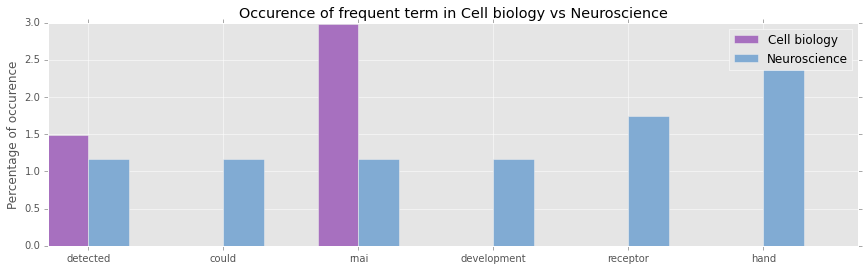

In [11]:
freqs_cb, freqs_n = [], []
R, N = range(3, 15, 2), len(range(3, 15, 2))

for j in R:
    cb = [int(i[1]) for i in topics_data[:, (1, j)] if i[0]=='Cell biology']
    n = [int(i[1]) for i in topics_data[:, (1, j)] if i[0]=='Neuroscience']
    cb_freq = sum(cb)*100./cb_total
    n_freq = sum(n)*100./n_total
    freqs_cb.append(cb_freq)
    freqs_n.append(n_freq)

ind = np.arange(N)
width = 0.3
fig, ax = plt.subplots()
rects_cb = ax.bar(ind, freqs_cb, width, color='#A770BF')
rects_n = ax.bar(ind+width, freqs_n, width, color='#81ABD3')

ax.set_ylabel('Percentage of occurence')
ax.set_title('Occurence of frequent term in Cell biology vs Neuroscience')
ax.set_xticks(ind+width)
xlabels = [header[i] for i in R]
ax.set_xticklabels(xlabels)
ax.legend((rects_cb[0], rects_n[0]), ('Cell biology', 'Neuroscience'))

fig.subplots_adjust(right=2)

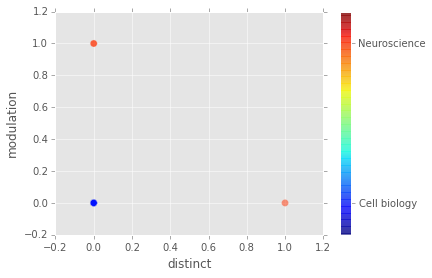

In [12]:
#x_index, y_index = 48, 350
x_index, y_index = 859, 179

classes = ['Cell biology', 'Neuroscience']
formatter = plt.FuncFormatter(lambda i, *args: classes[int(i)])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
targets = le.transform(Y)

plt.scatter(topics_data[:, x_index], topics_data[:, y_index],
            s=50, c=targets, alpha=0.5)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.clim(-0.2, 1.2)
plt.xlabel(header[x_index])
plt.ylabel(header[y_index])

####How I executed my plan


STEP 3: Build a classifier to predict the subcategory of an article

-> Building a classifier

Naive Bayes classifier:

* Simple classifier applying Bayes' theorem

* Assumes independence of the features

* Widely used in different application (text categorisation)

* Doesn't require a very large dataset

In [13]:
## NAIVE BAYES classifier:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split

## Encode labels ('Cell biology', 'Neuroscience') as 0 and 1.
le = preprocessing.LabelEncoder()
le.fit(Y)
y_transformed = le.transform(Y)
#print Y
#print y_transformed
## => 1: Neuroscience, 0: Cell biology

## Randomly split the data between training and testing:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_transformed)

In [14]:
## Bernoulli NB classifier

nbmodel_train = BernoulliNB().fit(X_train, Y_train)
predicted_bnb = nbmodel_train.predict(X_test)

## Confusion matrix:
cm_bnb = metrics.confusion_matrix(Y_test, predicted_bnb)
print "True positive: ", cm_bnb[0][0]," - False negative: ", cm_bnb[0][1]
print "False positive: ", cm_bnb[1][0], " - True negative: ", cm_bnb[1][1]

True positive:  10  - False negative:  7
False positive:  3  - True negative:  40


In [15]:
## Bernoulli NB classifier

# Precision: fraction of retrieved instances that are relevant (TP / TP + FP)
# Recall: fraction of relevant instances that are retrieved
print metrics.classification_report(Y_test, predicted_bnb)

# Accuracy: overall correctness of the model
print "Accuracy: ", metrics.accuracy_score(Y_test, predicted_bnb) 

## => Test with a high precision and recall for class 1 = Neuroscience

             precision    recall  f1-score   support

          0       0.77      0.59      0.67        17
          1       0.85      0.93      0.89        43

avg / total       0.83      0.83      0.83        60

Accuracy:  0.833333333333


K-nearest neighbor algorithm:

* Predict the label of a new point from its neighbours

* Simplest classifier in Machine Learning

* Lazy learner: computationally demanding for large datasets

In [16]:
## K NEAREST NEIGHBOUR classifier
from sklearn import metrics
from sklearn import neighbors

X_train, X_test, Y_train, Y_test = train_test_split(X, y_transformed)

knn = neighbors.KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)
predicted_knn = knn.predict(X_test)

cm_knn = metrics.confusion_matrix(Y_test, predicted_knn)
print "True positive: %d - False negative: %d" % (cm_knn[0][0], cm_knn[0][1])
print "False positive: %d - True negative: %d \n" % (cm_knn[1][0], cm_knn[1][1])

True positive: 8 - False negative: 10
False positive: 5 - True negative: 37 



In [17]:
## K NEAREST NEIGHBOUR classifier

# Precision: fraction of retrieved instances that are relevant (TP / TP + FP)
# Recall: fraction of relevant instances that are retrieved
print metrics.classification_report(Y_test, predicted_knn)

# Accuracy: overall correctness of the model
print "Accuracy: ", metrics.accuracy_score(Y_test, predicted_knn) 

## => Test with a high precision and recall for class 1 = Neuroscience

             precision    recall  f1-score   support

          0       0.62      0.44      0.52        18
          1       0.79      0.88      0.83        42

avg / total       0.74      0.75      0.74        60

Accuracy:  0.75


In [18]:
## Model validation: test several training/testing data
# K fold cross validation: iterator that randomise the sampling

from sklearn.cross_validation import cross_val_score

kf = range(2, 21)

knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
nb = BernoulliNB()

means_knn, sds_knn, means_nb, sds_nb = [], [], [], []

for k in kf:
    knn_scores = cross_val_score(knn, X_train, Y_train, cv=k)
    nb_scores = cross_val_score(nb, X_train, Y_train, cv=k)
    means_knn.append(knn_scores.mean()) 
    sds_knn.append(knn_scores.std())
    means_nb.append(nb_scores.mean())
    sds_nb.append(nb_scores.std())

print means_knn
print sds_knn

[0.74307116104868909, 0.74854126146151712, 0.77028436539306111, 0.77063492063492067, 0.75300333704115685, 0.7373626373626373, 0.72686100131752307, 0.7321080478975216, 0.74248366013071898, 0.73689839572192506, 0.75823412698412695, 0.73710904480135242, 0.74731815803244372, 0.74654234654234641, 0.74300699300699302, 0.74581105169340467, 0.73591470258136926, 0.75804093567251463, 0.75569444444444445]
[0.0097378277153558068, 0.0039294625239596681, 0.036849480657926544, 0.049525335751818091, 0.055005815837847118, 0.035175822459327585, 0.042045989963185822, 0.054404434025065819, 0.064550549673863492, 0.065473035936487706, 0.063142873477736575, 0.06091209095622617, 0.061086699560089427, 0.083182950324958621, 0.093804744232841353, 0.08805579810894619, 0.077954833834140022, 0.084796581962805637, 0.089237489180885435]


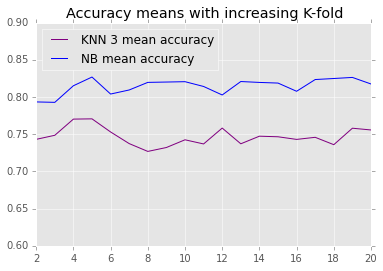

In [19]:
plt.plot(kf, means_knn, label="KNN 3 mean accuracy", color="purple")
plt.plot(kf, means_nb, label="NB mean accuracy", color="blue")
plt.legend(loc=2)
plt.ylim(0.6, 0.9)
plt.title("Accuracy means with increasing K-fold")

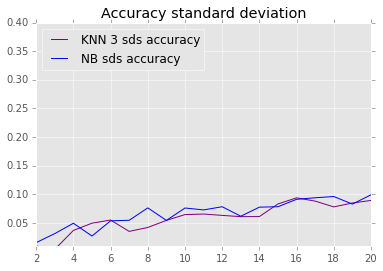

In [20]:
plt.plot(kf, sds_knn, label="KNN 3 sds accuracy", color="purple")
plt.plot(kf, sds_nb, label="NB sds accuracy", color="blue")
plt.legend(loc=2)
plt.ylim(0.01, 0.4)
plt.title("Accuracy standard deviation")

In [24]:
## 10 folds

X_train, X_test, Y_train, Y_test = train_test_split(X, y_transformed)

NB_train = BernoulliNB()
for i in range(10):
    NB_train.fit(X_train, Y_train)
    
import get_topics as gt

topics_test1 = gt.get_topics("articles/conrad2013_melanoma.txt")
print topics_test1

topics_test2 = gt.get_topics("articles/panizzo2014_cerebral_ischaemia.txt")
print topics_test2

test1 = [1 if h in topics_test1 else 0 for h in header[2:]]
test2 = [1 if h in topics_test2 else 0 for h in header[2:]]

NB_test1 = NB_train.predict(test1)
print NB_test1

NB_test2 = NB_train.predict(test2)
print NB_test2

[u'mouse', u'pathway', u'regulator', u'integrating', u'potential', u'identified', u'b16', u'data', u'pathway', u'potential']
[u'over', u'week', u'postischaemia', u'hour', u'cerebral', u'evolution', u'hypointense', u'cerebral', u'ischaemia', u'ischaemia']
[1]
[1]


####Getting meaning from scientific articles

1- Who I am

2- Goal of this project

3- My plan

4- First iteration

__5- Improvements__

6- Second iteration

7- Discussion

####Improvements



* Use article abstracts only


* Use Python 3 to avoid unicode issues


* Use the Latent Dirichet Allocation model

####Second iteration


__Topic modeling__

>"A __topic model__ is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents."

> http://en.wikipedia.org/wiki/Topic_model

* Latent Semantic Analysis (LSA)

-> Analyse relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms.


* Latent Derichelet Allocation (LDA)

-> Differs from LSA by assuming each document to be characterized by a mixture of various topics. 

####Second iteration

__Latent Derichelet Allocation (LDA) with Gensim__




In [9]:
from nltk.stem.wordnet import WordNetLemmatizer

from gensim import models
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS

from os import listdir
from os.path import isfile, join

import string 
import codecs
import time
import json


# Testing data: 2 Cell bio article abstracts

conrad2013 = """The inability of targeted BRAF inhibitors to produce long-lasting improvement in the clinical outcome of melanoma highlights a need to identify additional approaches to inhibit melanoma growth. 
            Recent studies have shown that activation of the Wnt/β-catenin pathway decreases tumor growth and cooperates with ERK/MAPK pathway inhibitors to promote apoptosis in melanoma. 
            Therefore, the identification of Wnt/β-catenin regulators may advance the development of new approaches to treat this disease. 
            In order to move towards this goal we performed a large scale small-interfering RNA (siRNA) screen for regulators of β-catenin activated reporter activity in human HT1080 fibrosarcoma cells. 
            Integrating large scale siRNA screen data with phosphoproteomic data and bioinformatics enrichment identified a protein, FAM129B, as a potential regulator of Wnt/β-catenin signaling.  
            Functionally, we demonstrated that siRNA-mediated knockdown of FAM129B in A375 and A2058 melanoma cell lines inhibits WNT3A-mediated activation of a β-catenin-responsive luciferase reporter and inhibits expression of the endogenous Wnt/β-catenin target gene, AXIN2. 
            We also demonstrate that FAM129B knockdown inhibits apoptosis in melanoma cells treated with WNT3A. These experiments support a role for FAM129B in linking Wnt/β-catenin signaling to apoptosis in melanoma.
            The incidence of melanoma continues to rise across the U.S. at a rate faster than any other cancer. Malignant melanoma has a poor prognosis with a 5-year survival rate of only 15%3. 
            The recently approved therapeutic, vemurafenib, extends median patient survival by 7 months. This major advance raises expectations that even greater rates of survival might be attainable with combination therapies."""

huang2015 = """Mouse GnT1IP-L, and membrane-bound GnT1IP-S (MGAT4D) expressed in cultured cells inhibit MGAT1, the N-acetylglucosaminyltransferase that initiates the synthesis of hybrid and complex N-glycans. 
            However, it is not known where in the secretory pathway GnT1IP-L inhibits MGAT1, nor whether GnT1IP-L inhibits other N-glycan branching N-acetylglucosaminyltransferases of the medial Golgi. We show here that the luminal domain of GnT1IP-L contains its inhibitory activity. 
            Retention of GnT1IP-L in the endoplasmic reticulum (ER) via the N-terminal region of human invariant chain p33, with or without C-terminal KDEL, markedly reduced inhibitory activity. 
            Dynamic fluorescent resonance energy transfer (FRET) and bimolecular fluorescence complementation (BiFC) assays revealed homomeric interactions for GnT1IP-L in the ER, and heteromeric interactions with MGAT1 in the Golgi. 
            GnT1IP-L did not generate a FRET signal with MGAT2, MGAT3, MGAT4B or MGAT5 medial Golgi GlcNAc-tranferases. 
            GnT1IP/Mgat4d transcripts are expressed predominantly in spermatocytes and spermatids in mouse, and are reduced in men with impaired spermatogenesis."""

In [10]:
spe_char = {u'β': 'beta', u'α': 'alpha', u'µm': 'micron'}

def parse_text(text):
    "Gets a text and outputs a list of strings."
    doc = [text.replace(unicode(i), spe_char.get(i)) for i in text if i in spe_char.keys()] or [text]
    return doc

conrad2013_parsed = parse_text(conrad2013)

huang2015_parsed = parse_text(huang2015)

print conrad2013_parsed

['The inability of targeted BRAF inhibitors to produce long-lasting improvement in the clinical outcome of melanoma highlights a need to identify additional approaches to inhibit melanoma growth. \n            Recent studies have shown that activation of the Wnt/\xce\xb2-catenin pathway decreases tumor growth and cooperates with ERK/MAPK pathway inhibitors to promote apoptosis in melanoma. \n            Therefore, the identification of Wnt/\xce\xb2-catenin regulators may advance the development of new approaches to treat this disease. \n            In order to move towards this goal we performed a large scale small-interfering RNA (siRNA) screen for regulators of \xce\xb2-catenin activated reporter activity in human HT1080 fibrosarcoma cells. \n            Integrating large scale siRNA screen data with phosphoproteomic data and bioinformatics enrichment identified a protein, FAM129B, as a potential regulator of Wnt/\xce\xb2-catenin signaling.  \n            Functionally, we demonstrate

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [12]:
def get_tokens(text_parsed):
    "Gets a text and retrieves tokens."
    # Tokenisation
    texts = text_parsed[0].lower().replace('\n', ' ').replace('/', ' ').replace('-', ' ').split(' ')
    # Remove punctuation and stop words
    tokens = [filter(lambda x:x not in string.punctuation, i)
               for i in texts if i != '' and i not in STOPWORDS]
    tokens_cleaned = [i for i in tokens if len(i) > 2 and not i.isdigit()]
    return tokens_cleaned

conrad2013_tokens = get_tokens(conrad2013_parsed)

huang2015_tokens = get_tokens(huang2015_parsed)

print conrad2013_tokens

['inability', 'targeted', 'braf', 'inhibitors', 'produce', 'long', 'lasting', 'improvement', 'clinical', 'outcome', 'melanoma', 'highlights', 'need', 'identify', 'additional', 'approaches', 'inhibit', 'melanoma', 'growth', 'recent', 'studies', 'shown', 'activation', 'wnt', 'catenin', 'pathway', 'decreases', 'tumor', 'growth', 'cooperates', 'erk', 'mapk', 'pathway', 'inhibitors', 'promote', 'apoptosis', 'melanoma', 'therefore', 'identification', 'wnt', 'catenin', 'regulators', 'advance', 'development', 'new', 'approaches', 'treat', 'disease', 'order', 'goal', 'performed', 'large', 'scale', 'small', 'interfering', 'rna', 'sirna', 'screen', 'regulators', 'catenin', 'activated', 'reporter', 'activity', 'human', 'ht1080', 'fibrosarcoma', 'cells', 'integrating', 'large', 'scale', 'sirna', 'screen', 'data', 'phosphoproteomic', 'data', 'bioinformatics', 'enrichment', 'identified', 'protein', 'fam129b', 'potential', 'regulator', 'wnt', 'catenin', 'signaling', 'functionally', 'demonstrated', 'si

In [13]:
def lemmatize_tokens(tokens):
    "Gets tokens and retrieves lemmatised tokens."
    # Lemmatisation using nltk lemmatiser
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

conrad2013_lemma = lemmatize_tokens(conrad2013_tokens)

huang2015_lemma = lemmatize_tokens(huang2015_tokens)

print conrad2013_lemma

['inability', 'targeted', 'braf', u'inhibitor', 'produce', 'long', 'lasting', 'improvement', 'clinical', 'outcome', 'melanoma', u'highlight', 'need', 'identify', 'additional', u'approach', 'inhibit', 'melanoma', 'growth', 'recent', u'study', 'shown', 'activation', 'wnt', 'catenin', 'pathway', u'decrease', 'tumor', 'growth', 'cooperates', 'erk', 'mapk', 'pathway', u'inhibitor', 'promote', 'apoptosis', 'melanoma', 'therefore', 'identification', 'wnt', 'catenin', u'regulator', 'advance', 'development', 'new', u'approach', 'treat', 'disease', 'order', 'goal', 'performed', 'large', 'scale', 'small', 'interfering', 'rna', 'sirna', 'screen', u'regulator', 'catenin', 'activated', 'reporter', 'activity', 'human', 'ht1080', 'fibrosarcoma', u'cell', 'integrating', 'large', 'scale', 'sirna', 'screen', 'data', 'phosphoproteomic', 'data', 'bioinformatics', 'enrichment', 'identified', 'protein', 'fam129b', 'potential', 'regulator', 'wnt', 'catenin', 'signaling', 'functionally', 'demonstrated', 'sirna

In [14]:
def bag_of_words(lemma):
    "Takes in lemmatised words and returns a bow."
    # Create bag of words from dictionnary
    dictionary = Dictionary(lemma)
    dictionary.save('text.dict')
    bow = [dictionary.doc2bow(l) for l in lemma] # Calculates inverse document counts for all terms
    return (bow, dictionary)


docs = [conrad2013_lemma, huang2015_lemma] # testing corpus

bow, dictionary = bag_of_words(docs)

print "Bag of words representation of the first document (tuples are composed by token_id and multiplicity):\n", bow[0]
print
for i in range(5):
    print "In the document, topic_id %d (word %s) appears %d time[s]" %(bow[0][i][0], docs[0][bow[0][i][0]], bow[0][i][1])
print "..."

Bag of words representation of the first document (tuples are composed by token_id and multiplicity):
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 3), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 7), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 4), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 3), (54, 1), (55, 1), (56, 2), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 8), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 3), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 2), (96, 1), (97, 2), (98, 3), (99, 1), (100, 1

In [15]:
def lda_model(dictionary, bow):
    ldamodel = models.ldamodel.LdaModel(bow, num_topics=10, id2word=dictionary, passes=5)
    return ldamodel


lda = lda_model(dictionary, bow)

for index, score in sorted(lda[bow[1]], key=lambda tup: -1*tup[1]):
    print "Score: %f\nTopic: %s" %(score, lda.print_topic(index, 10))

Score: 0.990722
Topic: 0.080*gnt1ip + 0.027*golgi + 0.027*mgat1 + 0.018*activity + 0.018*reduced + 0.018*inhibitory + 0.018*interaction + 0.018*fret + 0.018*expressed + 0.018*medial


In [16]:
# Try the model on another article abstract:

burns2015 = """Duplication of the yeast centrosome (called the spindle pole body, SPB) is thought to occur through a series of discrete steps that culminate in insertion of the new SPB into the nuclear envelope (NE). 
            To better understand this process, we developed a novel two-color structured illumination microscopy with single-particle averaging (SPA-SIM) approach to study the localization of all 18 SPB components during duplication using endogenously expressed fluorescent protein derivatives. 
            The increased resolution and quantitative intensity information obtained using this method allowed us to demonstrate that SPB duplication begins by formation of an asymmetric Sfi1 filament at mitotic exit followed by Mps1-dependent assembly of a Spc29- and Spc42-dependent complex at its tip. 
            Our observation that proteins involved in membrane insertion, such as Mps2, Bbp1, and Ndc1, also accumulate at the new SPB early in duplication suggests that SPB assembly and NE insertion are coupled events during SPB formation in wild-type cells."""

burns2015_tokens = lemmatize_tokens(get_tokens(parse_text(burns2015)))

bow_vector = dictionary.doc2bow(burns2015_tokens)
for index, score in sorted(lda[bow_vector], key=lambda tup: -1*tup[1]):
    print "Score: %f\n Topic: %s" %(score, lda.print_topic(index, 5))

Score: 0.610076
 Topic: 0.044*melanoma + 0.039*catenin + 0.028*wnt + 0.023*fam129b + 0.017*cell
Score: 0.328385
 Topic: 0.080*gnt1ip + 0.027*golgi + 0.027*mgat1 + 0.018*activity + 0.018*reduced


In [17]:
def prepare_text_for_lda(text):
    # Clean
    doc = [text.replace(unicode(i), spe_char.get(i)) for i in text if i in spe_char.keys()] or [text]
    # Tokenise
    texts = doc[0].lower().replace('\n', ' ').replace('/', ' ').replace('-', ' ').split(' ')
    # Remove punctuation and stop words
    tokens = [filter(lambda x:x not in string.punctuation, i)
               for i in texts if i != '' and i not in STOPWORDS]
    tokens_cleaned = [i for i in tokens if len(i) > 2 and not i.isdigit()]
    # Lemmatise
    lmtzr = WordNetLemmatizer()
    lemmatised_text = [lmtzr.lemmatize(t) for t in tokens_cleaned]
    return lemmatised_text


def parse_from_file(text_file):
    "Retrieves the content of a text file"
    with codecs.open(text_file, mode='r', encoding='utf-8') as f:
        reader = f.read()
        return reader

 
from os import listdir
from os.path import isfile, join

# Gather the articles
filepath = "articles/Cell biology/"
articles = [f for f in listdir(filepath) if isfile(join(filepath, f))] or []
print "There are %d articles in this folder.\n" % len(articles)

# Create a corpus
corpus = [prepare_text_for_lda(parse_from_file(filepath + a)) for a in articles[:45]]

articles_bow, articles_dict = bag_of_words(corpus)

articles_lda = lda_model(articles_dict, articles_bow)

for i in range(5):
    for index, score in sorted(articles_lda[articles_bow[i]], key=lambda tup: -1*tup[1]):
        print "Article %s\n Score: %f - Topic: %s\n" %(articles[i], score, articles_lda.print_topic(index, 10))

There are 67 articles in this folder.

Article elife00772.txt
 Score: 0.999293 - Topic: 0.054*cell + 0.009*protein + 0.008*figure + 0.008*pom1 + 0.007*gfp + 0.005*membrane + 0.005*pom1p + 0.005*strain + 0.005*time + 0.005*intensity

Article elife00654.txt
 Score: 0.999173 - Topic: 0.020*protein + 0.019*cell + 0.012*membrane + 0.007*cavin + 0.006*figure + 0.006*ap2 + 0.006*cargo + 0.006*ift + 0.005*function + 0.005*cilium

Article elife02137.txt
 Score: 0.863058 - Topic: 0.022*cell + 0.011*protein + 0.010*cenp + 0.010*redox + 0.010*aging + 0.008*figure + 0.008*oxidation + 0.008*nadph + 0.008*yeast + 0.007*level

Article elife02137.txt
 Score: 0.082134 - Topic: 0.020*protein + 0.019*cell + 0.012*membrane + 0.007*cavin + 0.006*figure + 0.006*ap2 + 0.006*cargo + 0.006*ift + 0.005*function + 0.005*cilium

Article elife02137.txt
 Score: 0.053982 - Topic: 0.054*cell + 0.009*protein + 0.008*figure + 0.008*pom1 + 0.007*gfp + 0.005*membrane + 0.005*pom1p + 0.005*strain + 0.005*time + 0.005*inten

In [19]:
print "Cell biol article:"
cb_article = articles[50]
print cb_article

cb_tokens = prepare_text_for_lda(parse_from_file(filepath + cb_article))

cb_bow = articles_dict.doc2bow(cb_tokens)

for index, score in sorted(articles_lda[cb_bow], key=lambda tup: -1*tup[1]):
    print "\nScore: %f\nTopic: %s\n" %(score, articles_lda.print_topic(index, 10))
    
print "-" * 70
print "Neuro article:"  
filepath_ns = "articles/Neuroscience/"
articles_ns = [f for f in listdir(filepath_ns) if isfile(join(filepath_ns, f))] or []

ns_article = articles_ns[0]
print ns_article

ns_tokens = prepare_text_for_lda(parse_from_file(filepath_ns + ns_article))

ns_bow = articles_dict.doc2bow(ns_tokens)

for index, score in sorted(articles_lda[ns_bow], key=lambda tup: -1*tup[1]):
    print "\nScore: %f\nTopic: %s" %(score, articles_lda.print_topic(index, 10))

Cell biol article:
elife03307.txt

Score: 0.999176
Topic: 0.054*cell + 0.009*protein + 0.008*figure + 0.008*pom1 + 0.007*gfp + 0.005*membrane + 0.005*pom1p + 0.005*strain + 0.005*time + 0.005*intensity

----------------------------------------------------------------------
Neuro article:
elife05438.txt

Score: 0.364755
Topic: 0.020*protein + 0.019*cell + 0.012*membrane + 0.007*cavin + 0.006*figure + 0.006*ap2 + 0.006*cargo + 0.006*ift + 0.005*function + 0.005*cilium

Score: 0.336101
Topic: 0.054*cell + 0.009*protein + 0.008*figure + 0.008*pom1 + 0.007*gfp + 0.005*membrane + 0.005*pom1p + 0.005*strain + 0.005*time + 0.005*intensity

Score: 0.111372
Topic: 0.028*micos + 0.016*complex + 0.016*protein + 0.015*cell + 0.015*qil1 + 0.013*mitochondrial + 0.012*figure + 0.011*membrane + 0.010*cristae + 0.010*subunit

Score: 0.055396
Topic: 0.016*usp13 + 0.014*protein + 0.014*chac1 + 0.012*glutathione + 0.011*expression + 0.011*usp5 + 0.008*tagged + 0.007*activity + 0.007*figure + 0.006*mouse

S

1- Who I am

2- Goal of this project

3- My plan

4- First iteration

5- Improvements

6- Second iteration

__7- Discussion__

####Discussion

State of the project:

* LDA seems like a good tool to compare articles on their content

* Next step: train lda model on different types of articles

* Idea: use the number of topics to evalute the proximity with a subject

_______


Tools used:

* Python 2.7 and iPython notebook
* Nltk library for natural text processing (nlp)
* Gensim library for nlp and topic modeling
* Scikit-learn library for Machine Learning

##That's all folks!

<br/>
####Questions and suggestions welcome =)

<br/>
####@EleonoreMayola
<br/>
github.com/Eleonore9/get-articles-meaning

In [2]:
s = """

<style>

.rendered_html {
    font-family: "proxima-nova", helvetica;
    font-size: 120%;
    line-height: 1.3;
}

.rendered_html h1 {
    margin: 0.25em 0em 0.5em;
    color: #349675;
    text-align: center;
    line-height: 1.2; 
    page-break-before: always;
}

.rendered_html h2 {
    margin: 1.1em 0em 0.5em;
    color: #415EBF;
    text-align: center;
    line-height: 1.2;
}

.rendered_html h4 {
    margin-top: 1.2em;
    margin-bottom: 1.1em;
    color: #878383;
    line-height: 1.2;
}

h4.center {
    margin-left: 13em;
}

h4.left {
    margin-left: 9em;
}

.rendered_html p.ref {
    font-size: 70%;
}

.rendered_html h5 {
    margin: 1.1em 0em 0.5em;
    /*text-align: center;*/
    line-height: 1.1;
}

.rendered_html li {
    line-height: 1.5; 
}

.rendered_html p {
    /*text-align: center;*/
}
.rendered_html span {
    text-align: center;
    line-height: 0.5;
}
.prompt {
    font-size: 120%; 
}

.img_center {
    border-left: 200px;
}

.CodeMirror-lines {
    font-size: 120%; 
}

.output_area {
    font-size: 120%; 
}

#notebook {
    
}

</style>
"""
display(HTML(s))